In [ ]:
##############################
# STEP 1: SETUP & UNZIP
##############################
import os
import zipfile
import glob

# If on Colab, optionally mount Drive. If local, skip.
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!apt-get install -y unzip
!pip install rasterio
!pip install torch torchvision  # Just to ensure we have PyTorch
!pip install scikit-learn      # for optional clustering if needed

import os
import glob
import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

%matplotlib inline

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 80.5 MB/s eta 0:00:00


In [ ]:
# Suppose your zipped data is in 'my_data.zip' somewhere
zip_path = "/content/drive/MyDrive/Agri.zip"   # change to your actual path
output_dir = "/content/data_unzipped"

os.makedirs(output_dir, exist_ok=True)

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print("Data unzipped to:", output_dir)

Data unzipped to: /content/data_unzipped


In [ ]:
# Example: adapt to match your nested structure
deep_dir_path = os.path.join(
    output_dir,
    "Agri",
    "Paddy",
    "paddy_season4_RededgeMultispectral_20190917_05m",
    "000"
)

print("Deep directory path where .tif images are located:", deep_dir_path)

# Let's see what files are there
print("Files in deep_dir_path:", os.listdir(deep_dir_path))


Deep directory path where .tif images are located: /content/data_unzipped/Agri/Paddy/paddy_season4_RededgeMultispectral_20190917_05m/000
Files in deep_dir_path: ['IMG_0245_3.tif', 'IMG_0063_1.tif', 'IMG_0237_2.tif', 'IMG_0286_5.tif', 'IMG_0324_4.tif', 'IMG_0288_3.tif', 'IMG_0231_5.tif', 'IMG_0269_2.tif', 'IMG_0340_1.tif', 'IMG_0204_2.tif', 'IMG_0307_5.tif', 'IMG_0294_1.tif', 'IMG_0216_5.tif', 'IMG_0326_1.tif', 'IMG_0209_2.tif', 'IMG_0222_1.tif', 'IMG_0274_1.tif', 'IMG_0094_4.tif', 'IMG_0205_5.tif', 'IMG_0253_2.tif', 'IMG_0323_5.tif', 'IMG_0076_2.tif', 'IMG_0092_4.tif', 'IMG_0066_3.tif', 'IMG_0063_5.tif', 'IMG_0279_4.tif', 'IMG_0305_4.tif', 'IMG_0266_4.tif', 'IMG_0082_2.tif', 'IMG_0106_5.tif', 'IMG_0129_1.tif', 'IMG_0131_4.tif', 'IMG_0302_3.tif', 'IMG_0071_2.tif', 'IMG_0270_1.tif', 'IMG_0263_3.tif', 'IMG_0179_5.tif', 'IMG_0211_3.tif', 'IMG_0176_5.tif', 'IMG_0152_3.tif', 'IMG_0225_1.tif', 'IMG_0238_1.tif', 'IMG_0335_5.tif', 'IMG_0140_5.tif', 'IMG_0288_1.tif', 'IMG_0290_5.tif', 'IMG_0271_

In [ ]:
import re
from collections import defaultdict

all_tifs = sorted([f for f in os.listdir(deep_dir_path) if f.endswith(".tif")])
print("Total TIF files found in deep_dir_path:", len(all_tifs))

# Group them by prefix (e.g., IMG_0009)
grouped_files = defaultdict(list)
pattern = r"(IMG_\d+)_(\d+)\.tif"  # e.g. "IMG_0009_1.tif"

for tif_file in all_tifs:
    match = re.match(pattern, tif_file)
    if match:
        img_id = match.group(1)    # e.g. "IMG_0009"
        grouped_files[img_id].append(tif_file)

# Sort each group's file list by the numeric suffix (1..5)
for img_id in grouped_files:
    grouped_files[img_id] = sorted(
        grouped_files[img_id],
        key=lambda x: int(re.match(pattern, x).group(2))
    )

print("Number of image sets:", len(grouped_files))

# Inspect first group
sample_key = list(grouped_files.keys())[0]
print("Example group:", sample_key, "->", grouped_files[sample_key])


Total TIF files found in deep_dir_path: 1575
Number of image sets: 315
Example group: IMG_0009 -> ['IMG_0009_1.tif', 'IMG_0009_2.tif', 'IMG_0009_3.tif', 'IMG_0009_4.tif', 'IMG_0009_5.tif']


Processed 5-band & NDVI saved in: /content/processed_data


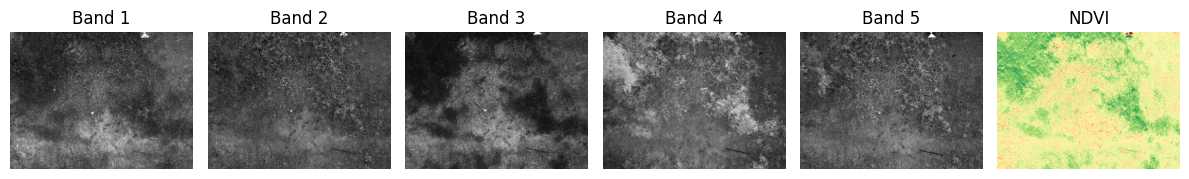

In [ ]:
##############################################
# 4. PREPROCESS: CROP, NDVI, SAVE
#    + PLOT A SAMPLE
##############################################
import numpy as np
import rasterio
import cv2
import matplotlib.pyplot as plt

def crop_black_borders(band_stack):
    """
    Crops out rows/cols where all bands are zero.
    band_stack: (bands, H, W)
    """
    non_zero_mask = np.any(band_stack != 0, axis=0)
    rows = np.any(non_zero_mask, axis=1)
    cols = np.any(non_zero_mask, axis=0)
    rmin, rmax = np.where(rows)[0][0], np.where(rows)[0][-1]
    cmin, cmax = np.where(cols)[0][0], np.where(cols)[0][-1]
    return band_stack[:, rmin:rmax+1, cmin:cmax+1]

def calculate_ndvi(band_stack, red_idx=2, nir_idx=4):
    """
    NDVI = (NIR - RED)/(NIR + RED)
    band order [B=0, G=1, R=2, RE=3, NIR=4]
    """
    red = band_stack[red_idx].astype(np.float32)
    nir = band_stack[nir_idx].astype(np.float32)
    with np.errstate(divide='ignore', invalid='ignore'):
        ndvi = (nir - red) / (nir + red)
        ndvi = np.nan_to_num(ndvi, nan=0.0, posinf=0.0, neginf=0.0)
    return ndvi

processed_dir = "/content/processed_data"
bands_dir = os.path.join(processed_dir, "bands")
ndvi_dir  = os.path.join(processed_dir, "ndvi")

os.makedirs(bands_dir, exist_ok=True)
os.makedirs(ndvi_dir,  exist_ok=True)

def stack_and_save_5bands(img_id, file_list):
    """
    Reads 5 .tif files => (5, H, W), crops black, NDVI, saves both.
    """
    band_arrays = []
    for tif_name in file_list:
        path = os.path.join(deep_dir_path, tif_name)
        with rasterio.open(path) as src:
            band_arrays.append(src.read(1))  # shape: (H, W)
    band_stack = np.stack(band_arrays, axis=0)  # (5, H, W)

    # Crop
    band_crop = crop_black_borders(band_stack)
    # NDVI
    ndvi_img = calculate_ndvi(band_crop, red_idx=2, nir_idx=4)

    # Save 5-band
    out_bands_path = os.path.join(bands_dir, f"{img_id}_bands.tif")
    with rasterio.open(os.path.join(deep_dir_path, file_list[0])) as ref_src:
        meta = ref_src.meta.copy()
    meta.update({
        'count': 5,
        'dtype': 'float32',
        'height': band_crop.shape[1],
        'width':  band_crop.shape[2]
    })
    with rasterio.open(out_bands_path, 'w', **meta) as dst:
        for i in range(5):
            dst.write(band_crop[i].astype(np.float32), i+1)

    # Save NDVI
    out_ndvi_path = os.path.join(ndvi_dir, f"{img_id}_ndvi.tif")
    meta.update({'count':1})
    with rasterio.open(out_ndvi_path, 'w', **meta) as dst:
        dst.write(ndvi_img.astype(np.float32), 1)

    return band_crop, ndvi_img

# Process all sets
for img_id, files in grouped_files.items():
    stack_and_save_5bands(img_id, files)

print("Processed 5-band & NDVI saved in:", processed_dir)

# PLOT a sample
sample_id = list(grouped_files.keys())[2]
sample_bands_path = os.path.join(bands_dir, f"{sample_id}_bands.tif")
sample_ndvi_path  = os.path.join(ndvi_dir,  f"{sample_id}_ndvi.tif")

with rasterio.open(sample_bands_path) as sb:
    sample_5stack = sb.read()  # shape: (5, H, W)
with rasterio.open(sample_ndvi_path) as sn:
    sample_ndvi = sn.read(1)

plt.figure(figsize=(12,4))
for i in range(5):
    plt.subplot(1,6,i+1)
    plt.imshow(sample_5stack[i], cmap='gray')
    plt.title(f"Band {i+1}")
    plt.axis('off')

plt.subplot(1,6,6)
plt.title("NDVI")
plt.imshow(sample_ndvi, cmap='RdYlGn')
plt.axis('off')
plt.tight_layout()
plt.show()


Pseudo masks saved in: /content/processed_data/masks


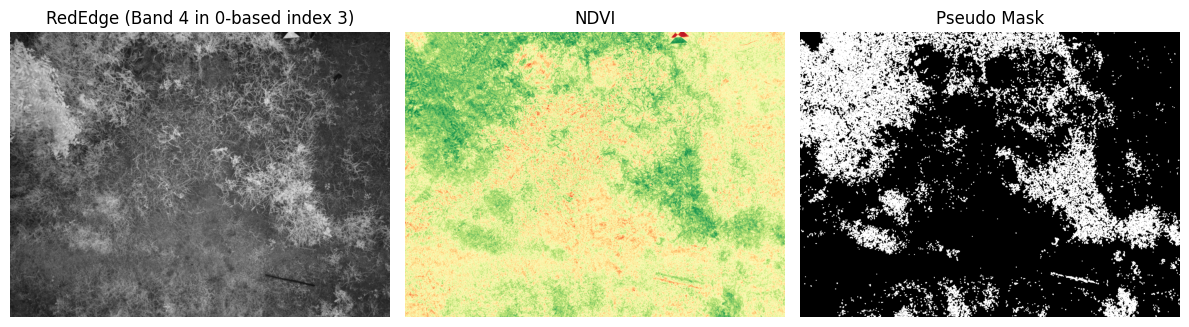

In [ ]:
##############################################
# 5. GENERATE PSEUDO MASK + PLOT
##############################################
masks_dir = os.path.join(processed_dir, "masks")
os.makedirs(masks_dir, exist_ok=True)

def pseudo_panicle_mask(bands_5, ndvi_img,
                        ndvi_min=0.2, ndvi_max=0.6,
                        rededge_idx=3, rededge_thresh=300):
    """
    bands_5 shape: (5, H, W), ndvi_img: (H, W)
    We'll pick NDVI in [ndvi_min, ndvi_max] & RedEdge >= rededge_thresh
    """
    ndvi_mask = (ndvi_img >= ndvi_min) & (ndvi_img <= ndvi_max)
    re_mask   = (bands_5[rededge_idx] >= rededge_thresh)
    combined  = ndvi_mask & re_mask
    mask_bin  = combined.astype(np.uint8)

    # morphological cleaning
    kernel = np.ones((3,3), np.uint8)
    mask_clean = cv2.morphologyEx(mask_bin, cv2.MORPH_OPEN, kernel)
    return mask_clean

import glob

for bp in glob.glob(os.path.join(bands_dir, "*_bands.tif")):
    fname = os.path.basename(bp)
    base_id = fname.replace("_bands.tif","")
    ndvi_path = os.path.join(ndvi_dir,  f"{base_id}_ndvi.tif")
    mask_path = os.path.join(masks_dir, f"{base_id}_mask.tif")

    if os.path.exists(ndvi_path):
        with rasterio.open(bp) as sb:
            bstack = sb.read()  # (5, H, W)
            meta_b = sb.meta.copy()
        with rasterio.open(ndvi_path) as sn:
            ndvi_img = sn.read(1)

        mask_pseudo = pseudo_panicle_mask(bstack, ndvi_img)
        meta_b.update({'count':1, 'dtype':'uint8'})
        with rasterio.open(mask_path, 'w', **meta_b) as dst:
            dst.write(mask_pseudo, 1)

print("Pseudo masks saved in:", masks_dir)

# Plot a sample mask
sample_mask_path = os.path.join(masks_dir, f"{sample_id}_mask.tif")
if os.path.exists(sample_mask_path):
    with rasterio.open(sample_mask_path) as s:
        pseudo_mask = s.read(1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title("RedEdge (Band 4 in 0-based index 3)")
    plt.imshow(sample_5stack[3], cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("NDVI")
    plt.imshow(sample_ndvi, cmap='RdYlGn')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Pseudo Mask")
    plt.imshow(pseudo_mask, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
##############################################
# 6. CREATE DATASET (BANDS+NDVI+MASK)
##############################################
import glob
from sklearn.model_selection import train_test_split

band_files = sorted(glob.glob(os.path.join(bands_dir, "*_bands.tif")))
data_list = []
for bp in band_files:
    base_id = os.path.basename(bp).replace("_bands.tif", "")
    ndvi_p  = os.path.join(ndvi_dir,  f"{base_id}_ndvi.tif")
    mask_p  = os.path.join(masks_dir, f"{base_id}_mask.tif")
    if os.path.exists(ndvi_p) and os.path.exists(mask_p):
        data_list.append((bp, ndvi_p, mask_p))

print("Total processed samples:", len(data_list))

trainval_list, test_list = train_test_split(data_list, test_size=0.2, random_state=42)
train_list, val_list = train_test_split(trainval_list, test_size=0.25, random_state=42)

print(f"Train: {len(train_list)}, Val: {len(val_list)}, Test: {len(test_list)}")

import torch
from torch.utils.data import Dataset, DataLoader

class PaddyPseudoDataset(Dataset):
    """
    Loads (5-band + NDVI) => (6, H, W), plus a mask => (1, H, W).
    Optionally resize for memory saving.
    """
    def __init__(self, samples, resize_hw=(256,256)):
        self.samples = samples
        self.resize_hw = resize_hw

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        band_path, ndvi_path, mask_path = self.samples[idx]

        with rasterio.open(band_path) as sb:
            bands_5 = sb.read().astype(np.float32)  # (5, H, W)
        with rasterio.open(ndvi_path) as sn:
            ndvi_img = sn.read(1).astype(np.float32) # (H, W)
        ndvi_img = np.expand_dims(ndvi_img, axis=0)  # (1, H, W)

        image_6 = np.concatenate([bands_5, ndvi_img], axis=0)  # (6, H, W)

        with rasterio.open(mask_path) as sm:
            mask_img = sm.read(1).astype(np.float32) # (H, W)
        mask_img = np.expand_dims(mask_img, axis=0)  # (1, H, W)

        import cv2
        if self.resize_hw is not None:
            resized_channels = []
            for i in range(6):
                ch = image_6[i]
                ch_res = cv2.resize(ch, (self.resize_hw[1], self.resize_hw[0]),
                                    interpolation=cv2.INTER_AREA)
                resized_channels.append(ch_res)
            image_6 = np.stack(resized_channels, axis=0)

            mk_res = cv2.resize(mask_img[0], (self.resize_hw[1], self.resize_hw[0]),
                                interpolation=cv2.INTER_NEAREST)
            mask_img = np.expand_dims(mk_res, axis=0)

        image_6 = torch.from_numpy(image_6)
        mask_img = torch.from_numpy(mask_img)
        return image_6, mask_img

train_dataset = PaddyPseudoDataset(train_list, resize_hw=(256,256))
val_dataset   = PaddyPseudoDataset(val_list,   resize_hw=(256,256))
test_dataset  = PaddyPseudoDataset(test_list,  resize_hw=(256,256))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=0)

Total processed samples: 315
Train: 189, Val: 63, Test: 63


In [ ]:
##############################################
# 7. SEGNET-LIKE MODEL
##############################################
import torch.nn as nn
import torch.optim as optim
import gc

class SegNetLike(nn.Module):
    """
    A simplified SegNet-like architecture for demonstration.
    """
    def __init__(self, in_channels=6, out_channels=1):
        super().__init__()
        self.enc_conv1 = self.double_conv(in_channels, 64)
        self.enc_conv2 = self.double_conv(64, 128)
        self.enc_conv3 = self.double_conv(128, 256)
        self.enc_conv4 = self.double_conv(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.dec_conv4 = self.double_conv(512, 256)
        self.dec_conv3 = self.double_conv(256, 128)
        self.dec_conv2 = self.double_conv(128, 64)
        self.dec_conv1 = self.double_conv(64, 64)

        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def double_conv(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc_conv1(x)
        p1 = self.pool(e1)
        e2 = self.enc_conv2(p1)
        p2 = self.pool(e2)
        e3 = self.enc_conv3(p2)
        p3 = self.pool(e3)
        e4 = self.enc_conv4(p3)
        p4 = self.pool(e4)

        # Decoder
        d4_up = self.upsample(p4)
        d4    = self.dec_conv4(d4_up)
        d3_up = self.upsample(d4)
        d3    = self.dec_conv3(d3_up)
        d2_up = self.upsample(d3)
        d2    = self.dec_conv2(d2_up)
        d1_up = self.upsample(d2)
        d1    = self.dec_conv1(d1_up)

        out = self.out_conv(d1)
        return out


In [ ]:
##############################################
# 8. TRAINING & VALIDATION (CPU)
##############################################
def dice_coeff(pred, target, smooth=1e-5):
    pred_bin = (torch.sigmoid(pred) > 0.5).float()
    intersection = (pred_bin * target).sum(dim=(1,2,3))
    union = pred_bin.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice.mean()

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    epoch_loss = 0.0
    epoch_dice = 0.0
    for images, masks in loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_dice += dice_coeff(outputs, masks).item()

        del images, masks, outputs, loss
        gc.collect()

    return epoch_loss / len(loader), epoch_dice / len(loader)

def validate_one_epoch(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    with torch.no_grad():
        for images, masks in loader:
            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            val_dice += dice_coeff(outputs, masks).item()

            del images, masks, outputs, loss
            gc.collect()

    return val_loss / len(loader), val_dice / len(loader)

model_segnet = SegNetLike(in_channels=6, out_channels=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_segnet.parameters(), lr=1e-4)
num_epochs = 25

train_loss_history = []
train_dice_history = []
val_loss_history   = []
val_dice_history   = []

for epoch in range(num_epochs):
    tr_loss, tr_dice = train_one_epoch(model_segnet, train_loader, optimizer, criterion)
    va_loss, va_dice = validate_one_epoch(model_segnet, val_loader, criterion)

    train_loss_history.append(tr_loss)
    train_dice_history.append(tr_dice)
    val_loss_history.append(va_loss)
    val_dice_history.append(va_dice)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {tr_loss:.4f}, Train Dice: {tr_dice:.4f} | "
          f"Val Loss: {va_loss:.4f}, Val Dice: {va_dice:.4f}")


Epoch [1/25] | Train Loss: 0.4717, Train Dice: 0.2793 | Val Loss: 0.5870, Val Dice: 0.0000
Epoch [2/25] | Train Loss: 0.3937, Train Dice: 0.3048 | Val Loss: 0.4142, Val Dice: 0.2806
Epoch [3/25] | Train Loss: 0.3666, Train Dice: 0.3327 | Val Loss: 0.3738, Val Dice: 0.3260
Epoch [4/25] | Train Loss: 0.3479, Train Dice: 0.3234 | Val Loss: 0.3337, Val Dice: 0.3927
Epoch [5/25] | Train Loss: 0.3373, Train Dice: 0.3555 | Val Loss: 0.3249, Val Dice: 0.3340
Epoch [6/25] | Train Loss: 0.3305, Train Dice: 0.3414 | Val Loss: 0.3314, Val Dice: 0.3233
Epoch [7/25] | Train Loss: 0.3254, Train Dice: 0.3472 | Val Loss: 0.3029, Val Dice: 0.3689
Epoch [8/25] | Train Loss: 0.3206, Train Dice: 0.3600 | Val Loss: 0.3034, Val Dice: 0.3820
Epoch [9/25] | Train Loss: 0.3124, Train Dice: 0.3744 | Val Loss: 0.2970, Val Dice: 0.3582
Epoch [10/25] | Train Loss: 0.3089, Train Dice: 0.3753 | Val Loss: 0.2926, Val Dice: 0.3551
Epoch [11/25] | Train Loss: 0.3134, Train Dice: 0.3710 | Val Loss: 0.3241, Val Dice: 0.41

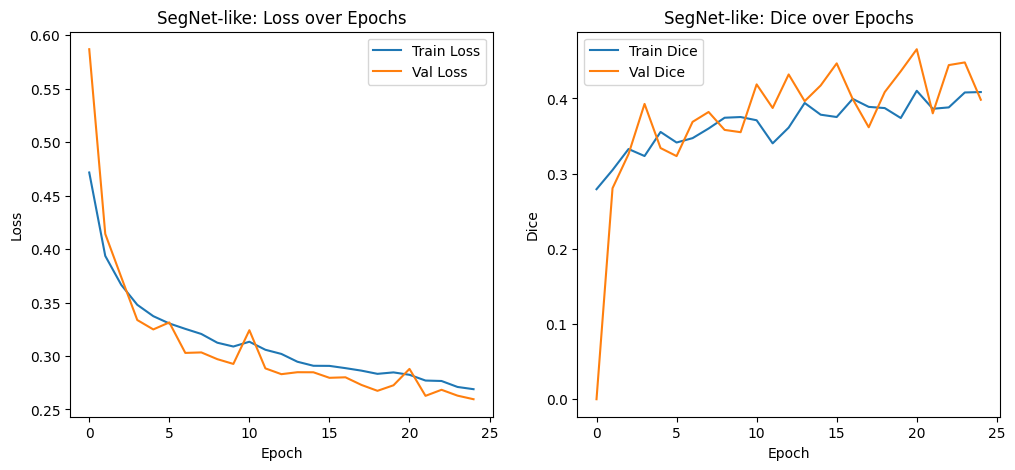

Test Loss: 0.2919, Test Dice: 0.4123


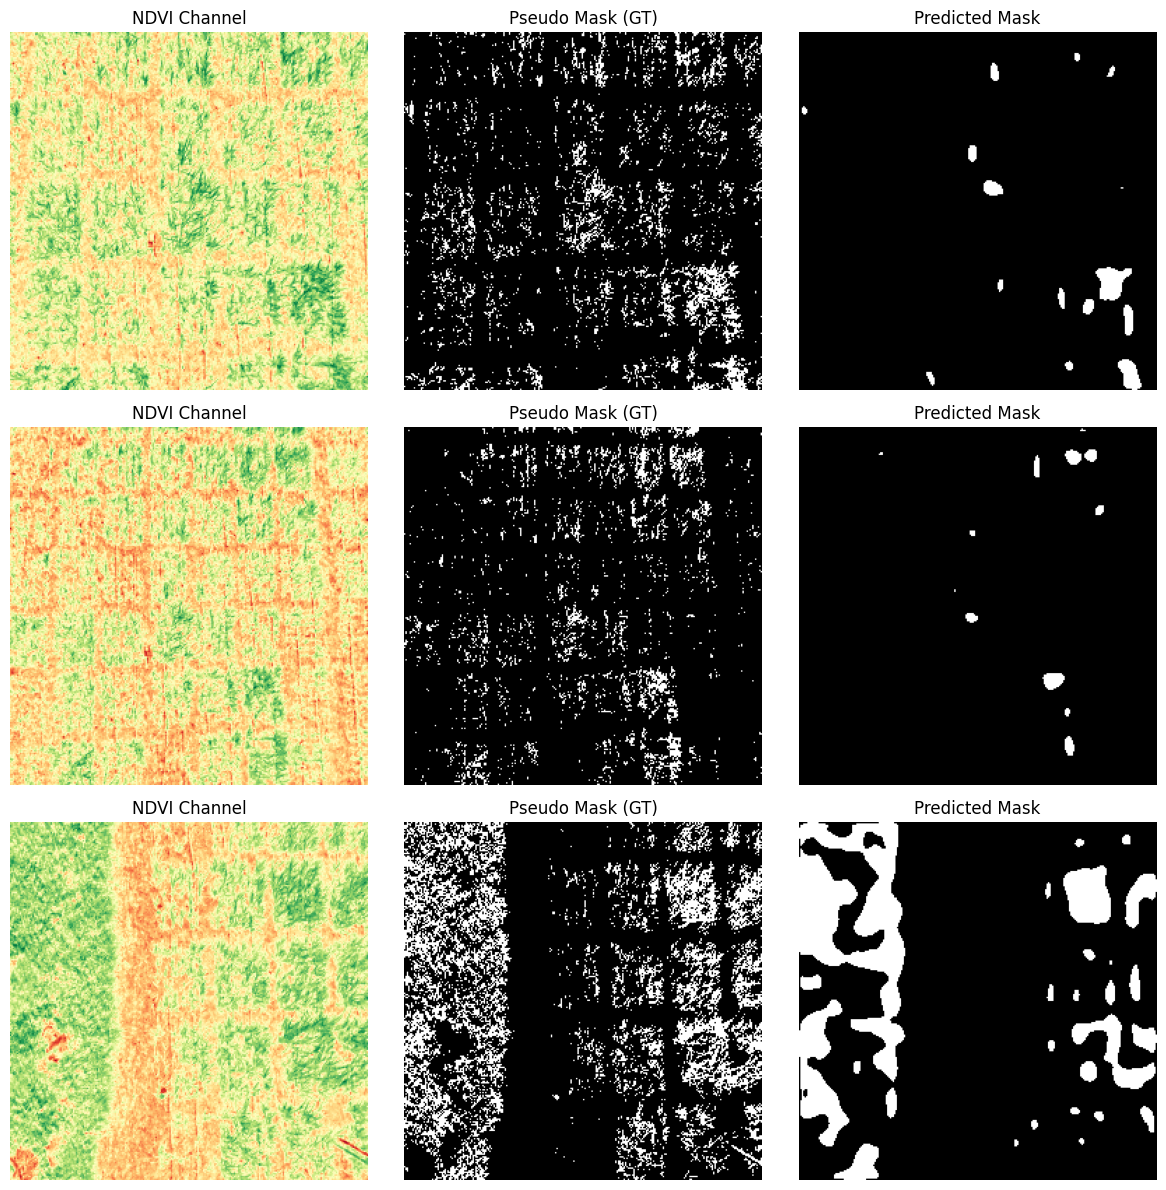

In [ ]:
##############################################
# 9. PLOT TRAINING CURVES & SAMPLE PREDICTIONS
##############################################
# PLOT LOSS & DICE
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SegNet-like: Loss over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_dice_history, label='Train Dice')
plt.plot(val_dice_history,   label='Val Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.title('SegNet-like: Dice over Epochs')
plt.legend()

plt.show()

# EVALUATE ON TEST SET
test_loss = 0.0
test_dice = 0.0
model_segnet.eval()
with torch.no_grad():
    for images, masks in test_loader:
        outputs = model_segnet(images)
        loss = criterion(outputs, masks)
        test_loss += loss.item()
        test_dice += dice_coeff(outputs, masks).item()

        del images, masks, outputs, loss
        gc.collect()

test_loss /= len(test_loader)
test_dice /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Dice: {test_dice:.4f}")

# VISUALIZE A FEW TEST PREDICTIONS
import random

n_samples_to_show = 3
indices = random.sample(range(len(test_dataset)), n_samples_to_show)

plt.figure(figsize=(12, 4*n_samples_to_show))
for i, idx in enumerate(indices):
    image_6, mask_gt = test_dataset[idx]
    # shape: (6, H, W), (1, H, W)
    image_6_batch = image_6.unsqueeze(0)

    with torch.no_grad():
        pred = model_segnet(image_6_batch)
    pred_sigmoid = torch.sigmoid(pred)
    pred_bin = (pred_sigmoid > 0.5).float()

    pred_np = pred_bin.squeeze().numpy()
    mask_np = mask_gt.squeeze().numpy()
    ndvi_np = image_6[5].numpy()  # 6th channel is NDVI

    plt.subplot(n_samples_to_show, 3, i*3+1)
    plt.imshow(ndvi_np, cmap='RdYlGn')
    plt.title("NDVI Channel")
    plt.axis('off')

    plt.subplot(n_samples_to_show, 3, i*3+2)
    plt.imshow(mask_np, cmap='gray')
    plt.title("Pseudo Mask (GT)")
    plt.axis('off')

    plt.subplot(n_samples_to_show, 3, i*3+3)
    plt.imshow(pred_np, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()

## **Attention+UNet**

In [ ]:
import glob
from sklearn.model_selection import train_test_split

band_files = sorted(glob.glob(os.path.join(bands_dir, "*_bands.tif")))
data_list = []
for bp in band_files:
    base_id = os.path.basename(bp).replace("_bands.tif","")
    ndvi_p  = os.path.join(ndvi_dir,  f"{base_id}_ndvi.tif")
    mask_p  = os.path.join(masks_dir, f"{base_id}_mask.tif")
    if os.path.exists(ndvi_p) and os.path.exists(mask_p):
        data_list.append((bp, ndvi_p, mask_p))

print("Total dataset items:", len(data_list))

trainval_list, test_list = train_test_split(data_list, test_size=0.2, random_state=42)
train_list, val_list     = train_test_split(trainval_list, test_size=0.25, random_state=42)
print(f"Train: {len(train_list)}, Val: {len(val_list)}, Test: {len(test_list)}")


Total dataset items: 315
Train: 189, Val: 63, Test: 63


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class PaddyPseudoDataset(Dataset):
    """
    (5-band + NDVI) => (6, H, W). Also 1-channel mask => (1, H, W).
    """
    def __init__(self, samples, resize_hw=(256,256)):
        self.samples = samples
        self.resize_hw = resize_hw

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        import cv2

        b_path, n_path, m_path = self.samples[idx]
        with rasterio.open(b_path) as sb:
            bands_5 = sb.read().astype(np.float32)  # (5, H, W)
        with rasterio.open(n_path) as sn:
            ndvi_img = sn.read(1).astype(np.float32) # (H, W)
        ndvi_img = np.expand_dims(ndvi_img, axis=0)  # -> (1, H, W)
        image_6 = np.concatenate([bands_5, ndvi_img], axis=0)  # -> (6, H, W)

        with rasterio.open(m_path) as sm:
            mask_img = sm.read(1).astype(np.float32) # (H, W)
        mask_img = np.expand_dims(mask_img, axis=0)  # (1, H, W)

        # Resize for memory saving
        if self.resize_hw is not None:
            resized_channels = []
            for i in range(6):
                ch = image_6[i]
                ch_res = cv2.resize(ch, (self.resize_hw[1], self.resize_hw[0]),
                                    interpolation=cv2.INTER_AREA)
                resized_channels.append(ch_res)
            image_6 = np.stack(resized_channels, axis=0)

            m_res = cv2.resize(mask_img[0],
                               (self.resize_hw[1], self.resize_hw[0]),
                               interpolation=cv2.INTER_NEAREST)
            mask_img = np.expand_dims(m_res, axis=0)

        image_6 = torch.from_numpy(image_6)   # (6, H, W)
        mask_img = torch.from_numpy(mask_img) # (1, H, W)
        return image_6, mask_img

train_dataset = PaddyPseudoDataset(train_list, (256,256))
val_dataset   = PaddyPseudoDataset(val_list,   (256,256))
test_dataset  = PaddyPseudoDataset(test_list,  (256,256))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=0)

print("Train loader:", len(train_loader), "batches")
print("Val loader:",   len(val_loader),   "batches")
print("Test loader:",  len(test_loader),  "batches")


Train loader: 12 batches
Val loader: 4 batches
Test loader: 2 batches


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionBlock(nn.Module):
    """
    Attention Gate as described in "Attention U-Net."
    Gating signal from decoder, skip input from encoder.
    """
    def __init__(self, F_g, F_l, F_int):
        """
        F_g: channels of gating signal
        F_l: channels of skip connection
        F_int: internal channels for the attention block
        """
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, g):
        """
        x: skip connection from encoder
        g: gating signal from decoder
        """
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


In [ ]:
class DoubleConv(nn.Module):
    """
    Basic double conv + BN + ReLU block.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class AttnUNet(nn.Module):
    """
    Attention U-Net with attention gates in skip connections.
    in_channels = 6 for (5 bands + NDVI).
    out_channels = 1 for binary segmentation.
    """
    def __init__(self, in_channels=6, out_channels=1):
        super().__init__()
        self.dc1 = DoubleConv(in_channels, 64)
        self.dc2 = DoubleConv(64, 128)
        self.dc3 = DoubleConv(128, 256)
        self.dc4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024)

        # Up sampling
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.att4 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.dc_up4 = DoubleConv(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att3 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.dc_up3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att2 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.dc_up2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att1 = AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.dc_up1 = DoubleConv(128, 64)

        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encode
        c1 = self.dc1(x)     # (64)
        p1 = self.pool(c1)
        c2 = self.dc2(p1)    # (128)
        p2 = self.pool(c2)
        c3 = self.dc3(p2)    # (256)
        p3 = self.pool(c3)
        c4 = self.dc4(p3)    # (512)
        p4 = self.pool(c4)

        # Bottleneck
        cb = self.bottleneck(p4)  # (1024)

        # Decode
        u4 = self.up4(cb)              # gating signal u4 => 512 channels
        x4 = self.att4(c4, u4)         # attention gate on c4
        cat4 = torch.cat([u4, x4], dim=1)
        c4_up = self.dc_up4(cat4)

        u3 = self.up3(c4_up)
        x3 = self.att3(c3, u3)
        cat3 = torch.cat([u3, x3], dim=1)
        c3_up = self.dc_up3(cat3)

        u2 = self.up2(c3_up)
        x2 = self.att2(c2, u2)
        cat2 = torch.cat([u2, x2], dim=1)
        c2_up = self.dc_up2(cat2)

        u1 = self.up1(c2_up)
        x1 = self.att1(c1, u1)
        cat1 = torch.cat([u1, x1], dim=1)
        c1_up = self.dc_up1(cat1)

        out = self.out_conv(c1_up)  # (batch, 1, H, W)
        return out


In [ ]:
import gc

def dice_coeff(pred, target, smooth=1e-5):
    pred_bin = (torch.sigmoid(pred) > 0.5).float()
    intersection = (pred_bin * target).sum(dim=(1,2,3))
    union = pred_bin.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice.mean()

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    epoch_loss = 0.0
    epoch_dice = 0.0
    for images, masks in loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_dice += dice_coeff(outputs, masks).item()

        del images, masks, outputs, loss
        gc.collect()

    return epoch_loss / len(loader), epoch_dice / len(loader)

def validate_one_epoch(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    with torch.no_grad():
        for images, masks in loader:
            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            val_dice += dice_coeff(outputs, masks).item()

            del images, masks, outputs, loss
            gc.collect()

    return val_loss / len(loader), val_dice / len(loader)

model_attn_unet = AttnUNet(in_channels=6, out_channels=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_attn_unet.parameters(), lr=1e-4)

num_epochs = 15

train_loss_history = []
train_dice_history = []
val_loss_history   = []
val_dice_history   = []

for epoch in range(num_epochs):
    tr_loss, tr_dice = train_one_epoch(model_attn_unet, train_loader, optimizer, criterion)
    va_loss, va_dice = validate_one_epoch(model_attn_unet, val_loader, criterion)

    train_loss_history.append(tr_loss)
    train_dice_history.append(tr_dice)
    val_loss_history.append(va_loss)
    val_dice_history.append(va_dice)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"| Train Loss: {tr_loss:.4f}, Train Dice: {tr_dice:.4f} "
          f"| Val Loss: {va_loss:.4f}, Val Dice: {va_dice:.4f}")


Epoch [1/15] | Train Loss: 0.5507, Train Dice: 0.4449 | Val Loss: 0.6320, Val Dice: 0.4582
Epoch [2/15] | Train Loss: 0.4523, Train Dice: 0.5561 | Val Loss: 0.5191, Val Dice: 0.5742
Epoch [3/15] | Train Loss: 0.4021, Train Dice: 0.5803 | Val Loss: 0.5370, Val Dice: 0.5987
Epoch [4/15] | Train Loss: 0.3866, Train Dice: 0.5688 | Val Loss: 0.3595, Val Dice: 0.5999
Epoch [5/15] | Train Loss: 0.3565, Train Dice: 0.5944 | Val Loss: 0.3397, Val Dice: 0.6144
Epoch [6/15] | Train Loss: 0.3438, Train Dice: 0.5844 | Val Loss: 0.3205, Val Dice: 0.6097
Epoch [7/15] | Train Loss: 0.3337, Train Dice: 0.5910 | Val Loss: 0.3304, Val Dice: 0.6149
Epoch [8/15] | Train Loss: 0.3221, Train Dice: 0.6190 | Val Loss: 0.3060, Val Dice: 0.6316
Epoch [9/15] | Train Loss: 0.3143, Train Dice: 0.6185 | Val Loss: 0.3056, Val Dice: 0.6369
Epoch [10/15] | Train Loss: 0.3089, Train Dice: 0.6245 | Val Loss: 1.1218, Val Dice: 0.6342
Epoch [11/15] | Train Loss: 0.3211, Train Dice: 0.6245 | Val Loss: 0.3663, Val Dice: 0.64